## TPE Tuning

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from dotenv import load_dotenv
import os

from sklearn.pipeline import Pipeline
from feature_engine.selection import DropConstantFeatures, DropDuplicateFeatures, SelectByShuffling

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from boruta import BorutaPy
from sklearn.experimental import enable_iterative_imputer
from sklearn.model_selection import train_test_split
from sklearn.impute import IterativeImputer
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import BayesianRidge

from sklearn.tree import DecisionTreeRegressor

import xgboost as xgb
from xgboost import XGBClassifier
from ngboost import NGBClassifier
from ngboost.distns import k_categorical

from sklearn.model_selection import StratifiedKFold, cross_validate, cross_val_score
from sklearn.metrics import accuracy_score, roc_auc_score, recall_score, precision_score, f1_score, balanced_accuracy_score

import optuna

c:\Users\steve\Desktop\Notebooks\Thesis-Project\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Import dataset
load_dotenv()
dataset_path=os.getenv("DATASET_PATH_H")
dataset = pd.read_csv(dataset_path)
dataset.head()

,RID,Gender,Ageatscreening,Diagnosis,MMSE0m,HipsASMbaseline,HipsContrastbaseline,HipsCorelationbaseline,HipsVariancebaseline,HipsSumAveragebaseline,...,ERCsContrastbaseline,ERCsCorelationbaseline,ERCsVariancebaseline,ERCsSumAveragebaseline,ERCsSumVariancebaseline,ERCsEntropybaseline,ERCsClusterShadebaseline,ERCs_thicknessbaseline,ERCsVolumebaseline,HipposcampusVolumebaseline
0,30865,0,73.697464,2,24.0,0.101093,175.393565,0.500722,173.535247,36.096518,...,323.798648,0.299493,221.695882,33.818211,587.066626,2.566872,4933.163606,2.563102,1220.610295,3064.823503
1,56,1,69.739700,0,28.0,0.212798,195.048004,0.548047,213.046946,31.734453,...,195.048004,0.548047,213.046946,31.734453,657.139780,3.031522,5550.425475,3.575500,1631.500000,3787.600000
2,30954,0,80.068440,2,17.0,0.143582,170.267530,0.545575,186.379698,36.728908,...,293.749080,0.414145,236.239837,32.057643,657.793732,2.890965,2170.192290,2.327126,791.995138,1978.973986
3,30236,1,69.656400,0,29.0,0.091508,181.028196,0.513832,184.033694,36.926329,...,204.766567,0.544235,226.620772,28.370820,695.606291,2.959220,-764.206140,3.064959,1750.726546,2795.938756
4,999,0,70.939700,2,25.0,0.148471,186.692642,0.611493,238.617863,36.628890,...,243.453948,0.468833,229.417825,28.994963,674.217352,2.885460,-1323.069060,2.545500,1191.500000,2914.950000


In [3]:
# Split by subject
subjects = dataset['RID'].unique()
first_diag_per_subject = dataset.groupby('RID')['Diagnosis'].first()

train_subs, test_subs = train_test_split(
    subjects,
    test_size=0.3,
    random_state=42,
    stratify=first_diag_per_subject
)

# Assign rows
train_df = dataset[dataset['RID'].isin(train_subs)].copy()
test_df  = dataset[dataset['RID'].isin(test_subs)].copy()

# Separate X and y
y_train = train_df['Diagnosis']
y_test  = test_df['Diagnosis']
X_train = train_df.drop(columns=['Diagnosis'])
X_test  = test_df.drop(columns=['Diagnosis'])

# -----------------------------
# Check for subject-level overlap
# -----------------------------
overlap_subjects = set(train_df['RID']).intersection(set(test_df['RID']))
if len(overlap_subjects) == 0:
    print("No subjects appear in both train and test sets.")
else:
    print(f"Overlapping subjects found: {overlap_subjects}")

print(f"Number of subjects in train: {len(train_df['RID'].unique())}")
print(f"Number of subjects in test: {len(test_df['RID'].unique())}")


No subjects appear in both train and test sets.
Number of subjects in train: 778
Number of subjects in test: 334


In [4]:
imputer_knn = IterativeImputer(
    estimator=DecisionTreeRegressor(),
    random_state=42,
)

imputer_knn.fit(X_train)
X_train_knn = imputer_knn.transform(X_train)
X_test_knn = imputer_knn.transform(X_test)

In [5]:
X_train_knn_t = pd.DataFrame(
    X_train_knn, 
    columns=X_train.columns, 
    index=X_train.index  # Critical fix
)
X_test_knn_t = pd.DataFrame(
    X_test_knn, 
    columns=X_test.columns, 
    index=X_test.index  # Critical fix
)

In [6]:
pipe = Pipeline([
    ('constant', DropConstantFeatures(tol=1, variables=None, missing_values='raise')),
    ('quasi-constant', DropConstantFeatures(tol=0.998, variables=None, missing_values='raise')),
    ('duplicated', DropDuplicateFeatures()),
])

pipe.fit(X_train_knn_t)

Pipeline(steps=[('constant', DropConstantFeatures()),
                ('quasi-constant', DropConstantFeatures(tol=0.998)),
                ('duplicated', DropDuplicateFeatures())])

In [7]:
X_train_t = pipe.transform(X_train_knn_t)
X_test_t = pipe.transform(X_test_knn_t)

X_train_t.shape, X_test_t.shape

((778, 23), (335, 23))

In [8]:
sel = ['RID', 'Ageatscreening', 'MMSE0m', 'HipsEntropybaseline',
       'HipsClusterShadebaseline', 'ERCsContrastbaseline',
       'ERCsCorelationbaseline', 'ERCs_thicknessbaseline',
       'ERCsVolumebaseline', 'HipposcampusVolumebaseline']

In [9]:
selected_features = [col for col in sel if col in X_train_t.columns]
selected_features

['RID',
 'Ageatscreening',
 'MMSE0m',
 'HipsEntropybaseline',
 'HipsClusterShadebaseline',
 'ERCsContrastbaseline',
 'ERCsCorelationbaseline',
 'ERCs_thicknessbaseline',
 'ERCsVolumebaseline',
 'HipposcampusVolumebaseline']

In [10]:
# Transform training and test sets using selected features
X_train_t = X_train_t[selected_features]
X_test_t = X_test_t[selected_features]

X_train_t.shape, X_test_t.shape

((778, 10), (335, 10))

## TPE

In [11]:
def objective(trial):
    
    
    skf = StratifiedKFold(n_splits=10,
                             shuffle=True,
                             random_state=42,
        )
        
    rf_n_estimators = trial.suggest_int("rf_n_estimators", 100, 300)
    rf_criterion = trial.suggest_categorical("rf_criterion", ['gini', 'entropy'])
    rf_max_depth = trial.suggest_int("rf_max_depth", 5, 20)
    rf_min_samples_split = trial.suggest_float("rf_min_samples_split", 0.01, 0.2)
    rf_max_features = trial.suggest_categorical("rf_max_features", ["sqrt", "log2", None])
    rf_min_samples_leaf = trial.suggest_float("rf_min_samples_leaf", 0.005, 0.05)
    rf_class_weight = trial.suggest_categorical("rf_class_weight", ["balanced", "balanced_subsample"])
        
    model = RandomForestClassifier(n_estimators=rf_n_estimators, 
                                   criterion=rf_criterion,
                                   max_depth=rf_max_depth,
                                   min_samples_split=rf_min_samples_split,
                                   max_features=rf_max_features,
                                   min_samples_leaf=rf_min_samples_leaf,
                                   random_state=42, 
                                   class_weight=rf_class_weight)

    score = cross_val_score(model, X_train_t, y_train, scoring="balanced_accuracy", cv=skf)
    
    accuracy = score.mean()
    
    return accuracy

In [12]:
study = optuna.create_study(
    direction="maximize",
    sampler=optuna.samplers.TPESampler(),
)

study.optimize(objective, n_trials=20)

[I 2025-11-13 22:09:59,237] A new study created in memory with name: no-name-5b6d07a2-b4f8-4033-a546-66807f7574e8
[I 2025-11-13 22:10:09,356] Trial 0 finished with value: 0.709812091503268 and parameters: {'rf_n_estimators': 290, 'rf_criterion': 'entropy', 'rf_max_depth': 12, 'rf_min_samples_split': 0.12607410081348439, 'rf_max_features': 'log2', 'rf_min_samples_leaf': 0.021547954407137103, 'rf_class_weight': 'balanced'}. Best is trial 0 with value: 0.709812091503268.
[I 2025-11-13 22:10:13,759] Trial 1 finished with value: 0.7274019607843136 and parameters: {'rf_n_estimators': 101, 'rf_criterion': 'gini', 'rf_max_depth': 15, 'rf_min_samples_split': 0.0733908930001629, 'rf_max_features': None, 'rf_min_samples_leaf': 0.04790395817377538, 'rf_class_weight': 'balanced'}. Best is trial 1 with value: 0.7274019607843136.
[I 2025-11-13 22:10:22,418] Trial 2 finished with value: 0.7134259259259259 and parameters: {'rf_n_estimators': 208, 'rf_criterion': 'gini', 'rf_max_depth': 5, 'rf_min_sampl

In [13]:
study.best_params

{'rf_n_estimators': 111,
 'rf_criterion': 'gini',
 'rf_max_depth': 16,
 'rf_min_samples_split': 0.08513475842759223,
 'rf_max_features': None,
 'rf_min_samples_leaf': 0.04918207422618507,
 'rf_class_weight': 'balanced_subsample'}

In [14]:
study.best_value

0.7288834422657952

In [15]:
r = study.trials_dataframe()
r.head()

,number,value,datetime_start,datetime_complete,duration,params_rf_class_weight,params_rf_criterion,params_rf_max_depth,params_rf_max_features,params_rf_min_samples_leaf,params_rf_min_samples_split,params_rf_n_estimators,state
0,0,0.709812,2025-11-13 22:09:59.240999,2025-11-13 22:10:09.356822,0 days 00:00:10.115823,balanced,entropy,12,log2,0.021548,0.126074,290,COMPLETE
1,1,0.727402,2025-11-13 22:10:09.356822,2025-11-13 22:10:13.759327,0 days 00:00:04.402505,balanced,gini,15,None,0.047904,0.073391,101,COMPLETE
2,2,0.713426,2025-11-13 22:10:13.760360,2025-11-13 22:10:22.417423,0 days 00:00:08.657063,balanced,gini,5,None,0.019890,0.167426,208,COMPLETE
3,3,0.714545,2025-11-13 22:10:22.419384,2025-11-13 22:10:27.874932,0 days 00:00:05.455548,balanced,gini,11,log2,0.040006,0.058280,190,COMPLETE
4,4,0.704888,2025-11-13 22:10:27.874932,2025-11-13 22:10:32.091874,0 days 00:00:04.216942,balanced,entropy,9,sqrt,0.008437,0.148333,114,COMPLETE


C:\Users\steve\AppData\Local\Temp\ipykernel_18580\2278197192.py:1: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  fig = optuna.visualization.matplotlib.plot_optimization_history(study)


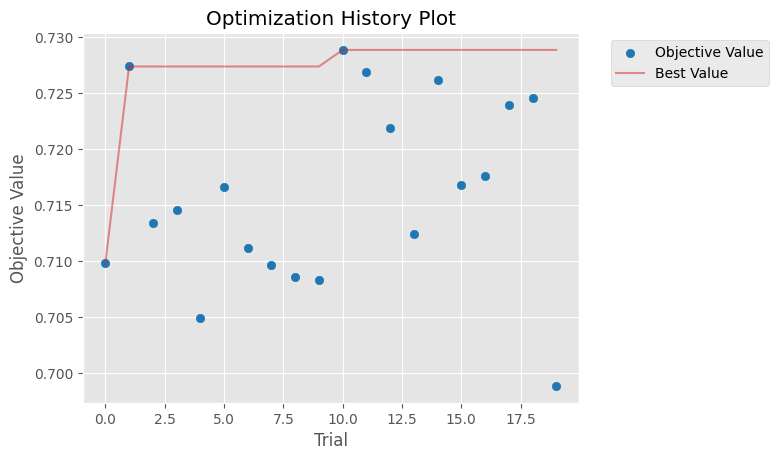

In [16]:
fig = optuna.visualization.matplotlib.plot_optimization_history(study)

C:\Users\steve\AppData\Local\Temp\ipykernel_18580\1036994904.py:1: ExperimentalWarning: plot_param_importances is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_param_importances(study)


<Axes: title={'left': 'Hyperparameter Importances'}, xlabel='Hyperparameter Importance', ylabel='Hyperparameter'>

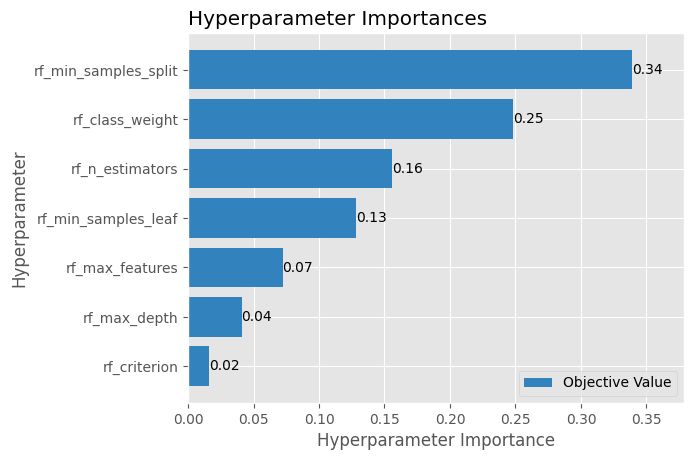

In [17]:
optuna.visualization.matplotlib.plot_param_importances(study)

C:\Users\steve\AppData\Local\Temp\ipykernel_18580\3879122787.py:1: ExperimentalWarning: plot_slice is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_slice(


array([<Axes: xlabel='rf_class_weight', ylabel='Objective Value'>,
       <Axes: xlabel='rf_criterion'>, <Axes: xlabel='rf_max_depth'>,
       <Axes: xlabel='rf_max_features'>,
       <Axes: xlabel='rf_min_samples_leaf'>,
       <Axes: xlabel='rf_min_samples_split'>,
       <Axes: xlabel='rf_n_estimators'>], dtype=object)

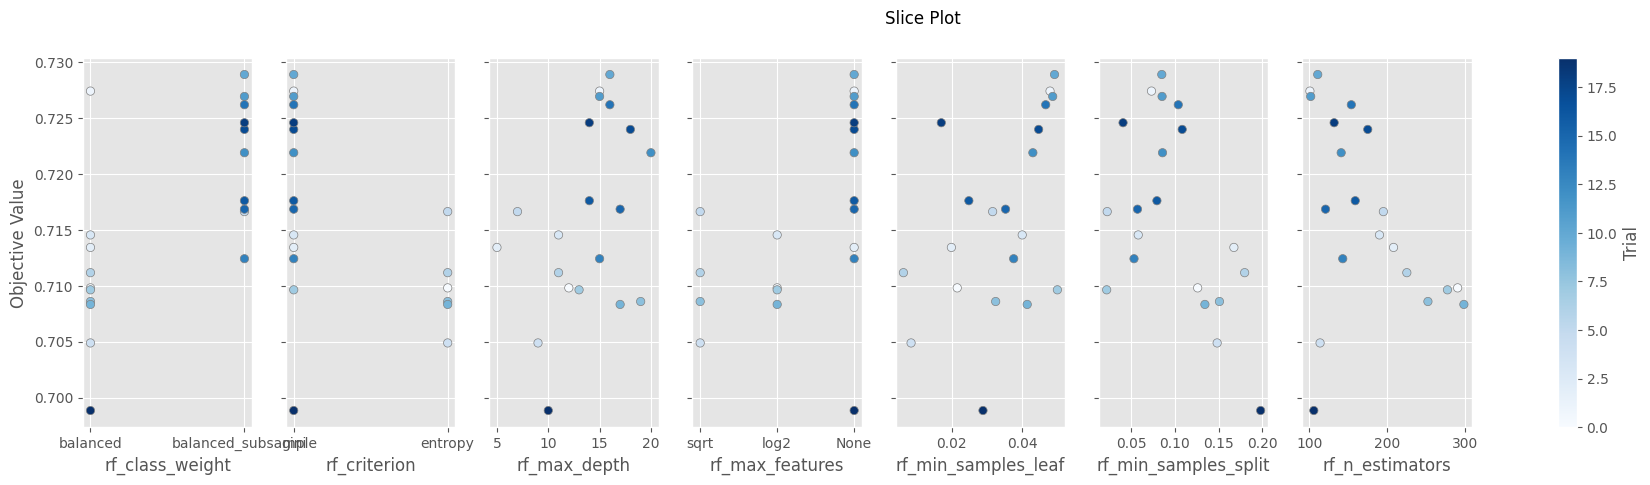

In [18]:
optuna.visualization.matplotlib.plot_slice(
    study,
    params=["rf_n_estimators", "rf_criterion", "rf_max_depth", 
            'rf_min_samples_split', 'rf_max_features', 'rf_min_samples_leaf',
            'rf_class_weight'],
)

C:\Users\steve\AppData\Local\Temp\ipykernel_18580\2601326980.py:1: ExperimentalWarning: plot_edf is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_edf([study])


<Axes: title={'center': 'Empirical Distribution Function Plot'}, xlabel='Objective Value', ylabel='Cumulative Probability'>

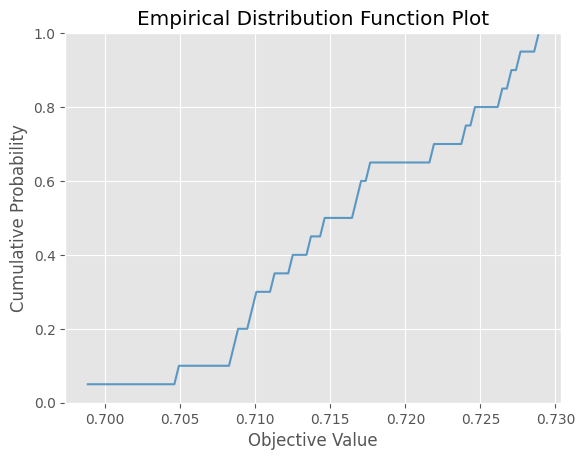

In [19]:
optuna.visualization.matplotlib.plot_edf([study])

## Classification

In [20]:
def run_model(classifier_name, sel_method, X_train, y_train):
        
        model = RandomForestClassifier(n_estimators=study.best_params["rf_n_estimators"], 
                                       criterion=study.best_params["rf_criterion"],
                                       max_depth=study.best_params["rf_max_depth"],
                                       min_samples_split=study.best_params["rf_min_samples_split"],
                                       max_features=study.best_params["rf_max_features"],
                                       min_samples_leaf=study.best_params["rf_min_samples_leaf"],
                                       random_state=42, 
                                       class_weight=study.best_params["rf_class_weight"])
        
        if sel_method == "Boruta":
                sel_method = "Boruta" 
        else: 
                sel_method = "Complete"
        
        skf = StratifiedKFold(n_splits=10,
                             shuffle=True,
                             random_state=42,
        )
        
        cross_val_results = cross_validate(model,
                                           X_train,
                                           y_train,
                                           cv=skf,
                                           scoring="balanced_accuracy",
                                           return_train_score=True,
        )
               
        # Calculate the metrics for training and testing
        mean_train = [round(np.mean(cross_val_results["train_score"]), 3)]
        std_train = [round(np.std(cross_val_results["train_score"]), 3)]
        mean_test = [round(np.mean(cross_val_results["test_score"]), 3)]
        std_test = [round(np.std(cross_val_results["test_score"]), 3)]
        time = round(np.mean(cross_val_results["fit_time"]), 3)
                
        cv_metrics_df = pd.DataFrame({
                "Feature Selection": sel_method,
                "Classifier": classifier_name,
                "Fit Time": time,
                "Total Features": len(X_train.columns),
                "Metric": "balanced_accuracy",
                "Mean Train": mean_train,
                "Std Train": std_train,
                "Mean Test": mean_test,
                "Std Test": std_test,
        })
        
        fit_model = model.fit(X_train, y_train)
        
        return fit_model, cv_metrics_df


In [21]:
trained_rf_n, metrics_rf_n = run_model("Random Forest", "Complete", X_train_knn_t, y_train)
trained_rf_t, metrics_rf_t = run_model("Random Forest", "Pearson", X_train_t, y_train)

In [22]:
from sklearn.utils import resample

def bootstrap_ci(model, X, y, metric_fn, n_iterations, ci=0.95, use_proba=False):
    scores = []
    n = len(X)
    for _ in range(n_iterations):
        X_resampled, y_resampled = resample(X, y, n_samples=n, stratify=y)
        try:
            y_pred = model.predict_proba(X_resampled) if use_proba else model.predict(X_resampled)
            score = metric_fn(y_resampled, y_pred)
            if not np.isnan(score):
                scores.append(score)
        except Exception:
            # Skip this bootstrap sample if error occurs (e.g. missing class for roc_auc)
            continue
    if len(scores) == 0:
        return (np.nan, np.nan)
    lower = np.percentile(scores, (1 - ci) / 2 * 100)
    upper = np.percentile(scores, (1 + ci) / 2 * 100)
    std_dev = np.std(scores)
    return round(lower, 3), round(upper, 3), round(std_dev, 3)

In [23]:
from sklearn.metrics import confusion_matrix

def compute_specificity(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    total = cm.sum()
    tp = np.diag(cm)
    fp = cm.sum(axis=0) - tp
    fn = cm.sum(axis=1) - tp
    tn = total - (tp + fp + fn)
    specificity = tn / (tn + fp)
    return round(np.nanmean(specificity), 3)

In [24]:
import time

def eval_model(classifier_name, model, X_train, X_test, y_train, y_test):
        
        if isinstance(X_train, np.ndarray):
                columns = X_train.shape[1]
        else:
                columns = len(X_train.columns)        
        
        start_time = time.time()
        # Get predicted probabilities for ROC AUC
        pred_train_proba = model.predict_proba(X_train)
        pred_test_proba = model.predict_proba(X_test)
        
        # Get predicted accuracy values
        pred_train = model.predict(X_train)
        pred_test = model.predict(X_test)
        
        # Calculate metrics
        # Calculate metrics
        metrics_train = {
                "accuracy": accuracy_score(y_train, pred_train),
                "balanced_accuracy": balanced_accuracy_score(y_train, pred_train),
                "precision_macro": precision_score(y_train, pred_train, average="macro", zero_division=0),
                "recall_macro": recall_score(y_train, pred_train, average="macro", zero_division=0),
                "f1_macro": f1_score(y_train, pred_train, average="macro", zero_division=0),
                "roc_auc_macro": roc_auc_score(y_train, pred_train_proba, average="macro", multi_class="ovr"),
                "specificity_macro": compute_specificity(y_train, pred_train),
        }

        metrics_test = {
                "accuracy": accuracy_score(y_test, pred_test),
                "balanced_accuracy": balanced_accuracy_score(y_test, pred_test),
                "precision_macro": precision_score(y_test, pred_test, average="macro", zero_division=0),
                "recall_macro": recall_score(y_test, pred_test, average="macro", zero_division=0),
                "f1_macro": f1_score(y_test, pred_test, average="macro", zero_division=0),
                "roc_auc_macro": roc_auc_score(y_test, pred_test_proba, average="macro", multi_class="ovr"),
                "specificity_macro": compute_specificity(y_test, pred_test),
        }
                
        elapsed_time = time.time() - start_time
        
        # Metric functions for bootstrap CI (exclude ROC AUC here)
        metric_fns = {
                "accuracy": accuracy_score,
                "balanced_accuracy": balanced_accuracy_score,
                "precision_macro": lambda yt, yp: precision_score(yt, yp, average="macro", zero_division=0),
                "recall_macro": lambda yt, yp: recall_score(yt, yp, average="macro", zero_division=0),
                "f1_macro": lambda yt, yp: f1_score(yt, yp, average="macro", zero_division=0),
                "roc_auc_macro": lambda yt, yp: roc_auc_score(yt, yp, average="macro", multi_class="ovr"),
                "specificity_macro": lambda yt, yp: compute_specificity(yt, yp),
        }

        # Bootstrap confidence intervals
        ci_test = {
                m: bootstrap_ci(
                model, X_test, y_test, fn,
                n_iterations=1000,
                use_proba=(m == "roc_auc_macro")
                )
                for m, fn in metric_fns.items()
        }

        # Separate CI bounds and std with clear variable names
        ci_bounds = []
        std_values = []
                
        for lower, upper, std in ci_test.values():
                ci_bounds.append(f"[{round(lower, 3)}, {round(upper, 3)}]")
                std_values.append(round(std, 3)) 
                
        # Round metric values
        train_rounded = [round(score, 3) for score in metrics_train.values()]
        test_rounded = [round(score, 3) for score in metrics_test.values()] 
    
        # Create the DataFrame without additional rounding
        pred_metrics_df = pd.DataFrame({
                "Feature Selection": "Spearman",
                "Classifier": classifier_name,
                "Classification Time": round(elapsed_time, 3),
                "Total Features": columns,
                "Metric": list(metrics_train.keys()),      
                "Train data": train_rounded,
                "Test data": test_rounded,
                "95% CI": ci_bounds,
                "Std Dev": std_values,
        })
        
        return pred_metrics_df

In [25]:
results = "all"
prediction_df_report = None

if results == "all":
    
    pred_rf_n = eval_model("Random Forest", trained_rf_n, X_train_knn_t, X_test_knn_t, y_train, y_test)
    pred_rf_t = eval_model("Random Forest", trained_rf_t, X_train_t, X_test_t, y_train, y_test)
    
    prediction_df = pd.concat([pred_rf_n, pred_rf_t])
    prediction_df_report = prediction_df.set_index(["Feature Selection", "Classifier", "Classification Time", "Total Features", "Metric"])
        
elif results == "filtered":
    
    pred_rf_t = eval_model("Random Forest", trained_rf_t, X_train_t, X_test_t, y_train, y_test)
  
    prediction_df = pd.concat([pred_rf_t])
    prediction_df_report = prediction_df.set_index(["Feature Selection", "Classifier", "Classification Time", "Total Features", "Metric"])

prediction_df_report

Train data  \
Feature Selection Classifier    Classification Time Total Features Metric                          
Spearman          Random Forest 0.246               23             accuracy                0.749   
                                                                   balanced_accuracy       0.750   
                                                                   precision_macro         0.710   
                                                                   recall_macro            0.750   
                                                                   f1_macro                0.722   
                                                                   roc_auc_macro           0.918   
                                                                   specificity_macro       0.877   
                                0.080               10             accuracy                0.751   
                                                                   balanced_accuracy       0.753   
                                                                   precision_macro         0.711   
                                                                   recall_macro            0.753   
                                                                   f1_macro                0.724   
                                                                   roc_auc_macro           0.914   
                                                                   specificity_macro       0.878   

                                                                                      Test data  \
Feature Selection Classifier    Classification Time Total Features Metric                         
Spearman          Random Forest 0.246               23             accuracy               0.690   
                                                                   balanced_accuracy      0.679   
                                                                   precision_macro        0.641   
                                                                   recall_macro           0.679   
                                                                   f1_macro               0.646   
                                                                   roc_auc_macro          0.877   
                                                                   specificity_macro      0.847   
                                0.080               10             accuracy               0.687   
                                                                   balanced_accuracy      0.681   
                                                                   precision_macro        0.638   
                                                                   recall_macro           0.681   
                                                                   f1_macro               0.644   
                                                                   roc_auc_macro          0.880   
                                                                   specificity_macro      0.847   

                                                                                              95% CI  \
Feature Selection Classifier    Classification Time Total Features Metric                              
Spearman          Random Forest 0.246               23             accuracy           [0.639, 0.737]   
                                                                   balanced_accuracy  [0.621, 0.733]   
                                                                   precision_macro    [0.595, 0.686]   
                                                                   recall_macro        [0.62, 0.737]   
                                                                   f1_macro            [0.59, 0.698]   
                                                                   roc_auc_macro      [0.843, 0.909]   
                                                                   s

### Export model

In [26]:
trained_rf_t

RandomForestClassifier(class_weight='balanced_subsample', max_depth=16,
                       max_features=None, min_samples_leaf=0.04918207422618507,
                       min_samples_split=0.08513475842759223, n_estimators=111,
                       random_state=42)

In [27]:
import pickle

with open("rf_model.pkl", "wb") as file:
    pickle.dump(trained_rf_t, file)
    
print("Random Forest model saved successfully!")

Random Forest model saved successfully!
